In [1]:
# # This file is part of Theano Geometry
#
# Copyright (C) 2017, Stefan Sommer (sommer@di.ku.dk)
# https://bitbucket.org/stefansommer/theanogemetry
#
# Theano Geometry is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# Theano Geometry is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with Theano Geometry. If not, see <http://www.gnu.org/licenses/>.
#

# LDDMM landmark dynamics

In [2]:
%cd ..
from src.manifolds.landmarks import *
M = landmarks(21)
print(M)

from src.plotting import *

/home/stefan/projects/theanogeometry
21 landmarks in R^2 (dim 42). kernel Gaussian, k_alpha=1, k_sigma=[[0.5 0. ]
 [0.  0.5]]


In [3]:
# Riemannian structure
from src.Riemannian import metric
metric.initialize(M)

q =  (array([-0.5 , -1.  , -0.5 , -0.75, -0.5 , -0.5 , -0.5 , -0.25, -0.5 ,
        0.  , -0.5 ,  0.25, -0.5 ,  0.5 , -0.5 ,  0.75, -0.5 ,  1.  ,
       -0.25,  0.  ,  0.  ,  0.  ,  0.25,  0.  ,  0.5 , -1.  ,  0.5 ,
       -0.75,  0.5 , -0.5 ,  0.5 , -0.25,  0.5 ,  0.  ,  0.5 ,  0.25,
        0.5 ,  0.5 ,  0.5 ,  0.75,  0.5 ,  1.  ]), array([0.]))
p =  [  2.19576288   2.19576288  -6.18666682  -6.18666682  11.42801205
  11.42801205 -15.32432311 -15.32432311  18.41579911  18.41579911
 -15.32432311 -15.32432311  11.42801205  11.42801205  -6.18666682
  -6.18666682   2.19576288   2.19576288  -3.84957846  -3.84957846
   5.10049307   5.10049307  -3.84957846  -3.84957846   2.19576288
   2.19576288  -6.18666682  -6.18666682  11.42801205  11.42801205
 -15.32432311 -15.32432311  18.41579911  18.41579911 -15.32432311
 -15.32432311  11.42801205  11.42801205  -6.18666682  -6.18666682
   2.19576288   2.19576288]


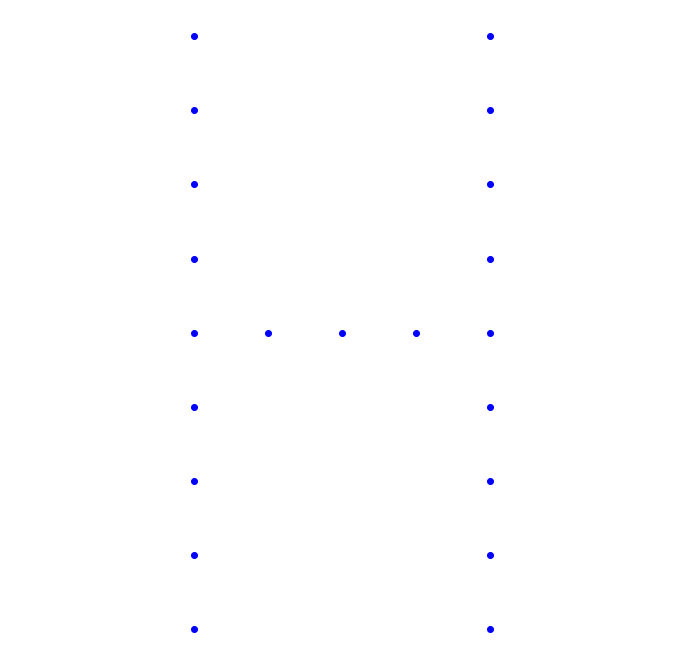

In [4]:
# example configuration
M.k_sigma.set_value(np.diag((.5,.5)))

q = M.coordsf(np.vstack((
    np.stack((-.5+np.zeros(int((M.N.eval()-3)/2)),np.linspace(-1.,1.,int((M.N.eval()-3)/2))),axis=1),
    np.array([[-.25,0.]]),
    np.array([[0.,0.]]),
    np.array([[.25,0.]]),
    np.stack((.5+np.zeros(int((M.N.eval()-3)/2)),np.linspace(-1.,1.,int((M.N.eval()-3)/2))),axis=1),    
)).flatten())
v = .5*np.vstack((np.ones(M.N.eval()),np.ones(M.N.eval()))).T.flatten()
p = M.flatf(q,v.flatten())
print("q = ", q)
print("p = ", p)
M.plot()
M.plotx(q)
plt.axis('off')
plt.savefig('shape.pdf')

## Brownian Motion

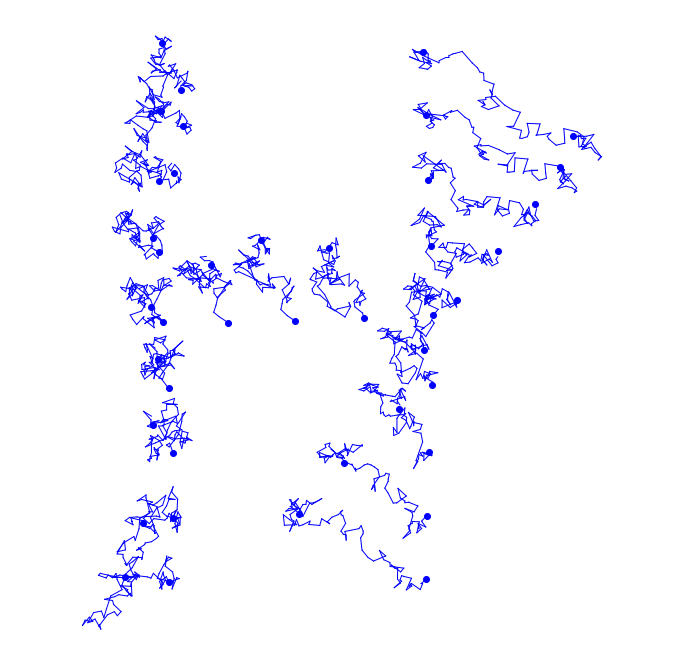

In [5]:
# coordinate form
from src.stochastics import Brownian_coords
Brownian_coords.initialize(M)

(ts,qs,charts) = M.Brownian_coordsf(q,.2*dWsf(M.dim.eval()))
M.plot()
M.plot_path(zip(qs,charts))
plt.axis('off')
plt.savefig('Brownian.pdf')
plt.show()

# Langevin equations
see https://arxiv.org/abs/1605.09276

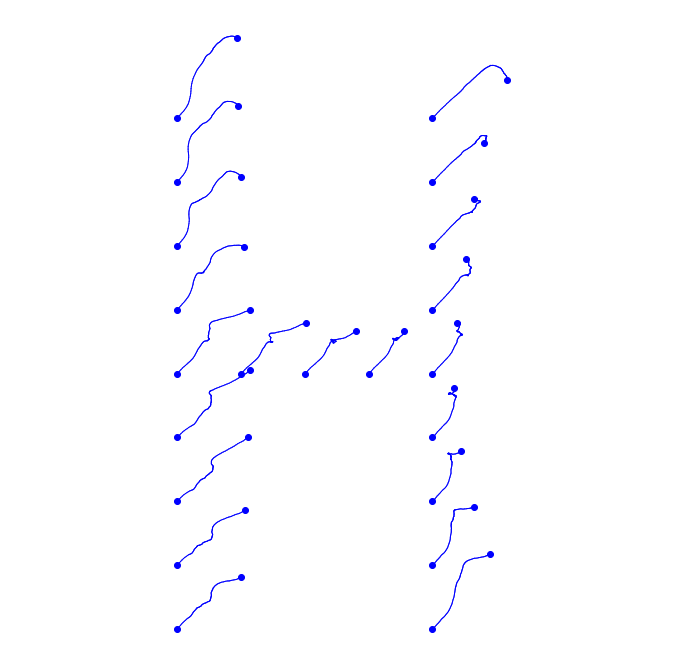

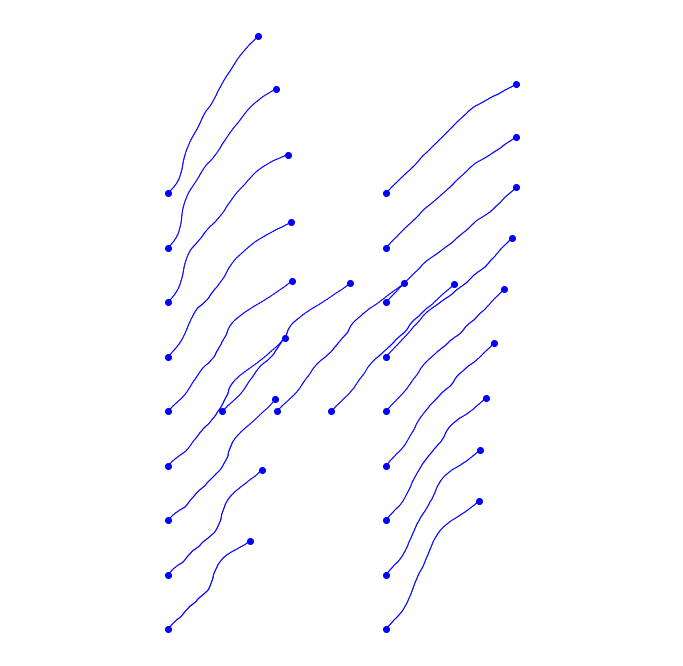

In [6]:
from src.stochastics import Langevin
Langevin.initialize(M)

dWs = dWsf(M.dim.eval())

(ts,qps,charts) = M.Langevinf(q,p,.5,.25,dWs)
M.plot()
M.plot_path(zip(qps[:,0,:],charts))
plt.axis('off')
plt.savefig('Langevin.pdf')
plt.show()

(ts,qps,charts) = M.Langevinf(q,p,0.,.25,dWs)
M.plot()
M.plot_path(zip(qps[:,0,:],charts))
plt.axis('off')
plt.savefig('Lagrangian.pdf')
plt.show()

## Stochastic EPDiff / Eulerian

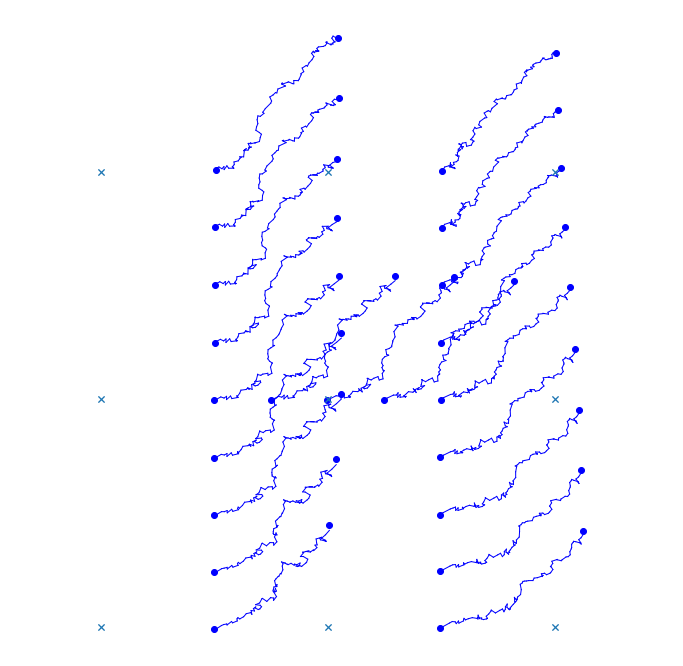

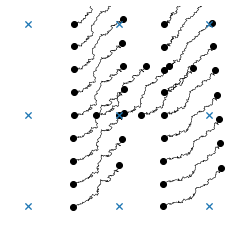

In [7]:
# define noise field grid
minx = -1; maxx = 1
miny = -1; maxy = 1
pts = 3

X, Y = np.meshgrid(np.linspace(minx,maxx,pts),np.linspace(miny,maxy,pts))
xy = np.vstack([X.ravel(), Y.ravel()]).T
sigmas_x = np.hstack((xy,xy)).reshape((-1,2))
sigmas_a = .05*np.tile(np.eye(2),(sigmas_x.shape[0]//2,1))
#sigmas_x = np.array([[0.,0.]])
#sigmas_a = np.array([[.1,0.]])
J = sigmas_x.shape[0]

# noise kernels
k_alpha = 1.
k_sigma = np.diag(((maxx-minx)/(pts-1),(maxy-miny)/(pts-1)))
inv_k_sigma = theano.tensor.nlinalg.MatrixInverse()(k_sigma)
k = lambda x: k_alpha*T.exp(-.5*T.sqr(T.tensordot(x,inv_k_sigma,(0 if x.type == T.vector().type else 2,1))).sum(0 if x.type == T.vector().type else 2))

# initialize with specified noise kernel
from src.stochastics import Eulerian
Eulerian.initialize(M,k=k)

# integrate
(ts,qps,charts) = M.Eulerianf(q,p,sigmas_x.flatten(),sigmas_a.flatten(),dWsf(J))
M.plot()
M.plot_path(zip(qps[:,0,:],charts))
plt.axis('off')
plt.plot(sigmas_x[:,0],sigmas_x[:,1],'x')
plt.savefig('Eulerian.pdf')
plt.show()

plt.figure(figsize=(4,4))
M.plot()
M.plot_path(zip(qps[:,0,:],charts), color='k', linewidth=0.5)
plt.plot(sigmas_x[:,0],sigmas_x[:,1],'x')
plt.axis('off')
plt.axis([-1.2, 1.2, -1.2, 1.2])
plt.savefig('Eulerian.svg')
plt.show()

# CC examples

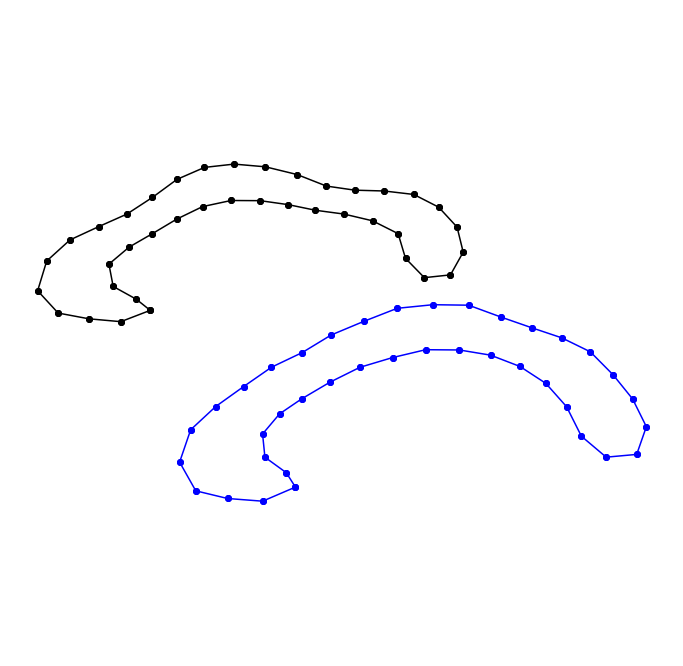

In [30]:
# load two cc shapes
(q,q1) = np.load('cc.npy',allow_pickle=True)
q = tuple(q); q1 = tuple(q1)

M.N.set_value(q[0].shape[0]/M.m.eval())
M.k_sigma.set_value(np.diag((.5,.5)))

disp = np.tile(np.array([1.1,-1.1]),(M.N.eval(),1)).flatten() # translation to improve visual appearance

M.plot()
M.plotx(q,color='black',curve=True)
M.plotx((q1[0]+disp,),curve=True)
plt.axis('off')
plt.savefig('cc_shape.pdf')

v = .5*np.vstack((np.ones(M.N.eval()),np.ones(M.N.eval()))).T.flatten()
p = M.flatf(q,v.flatten())

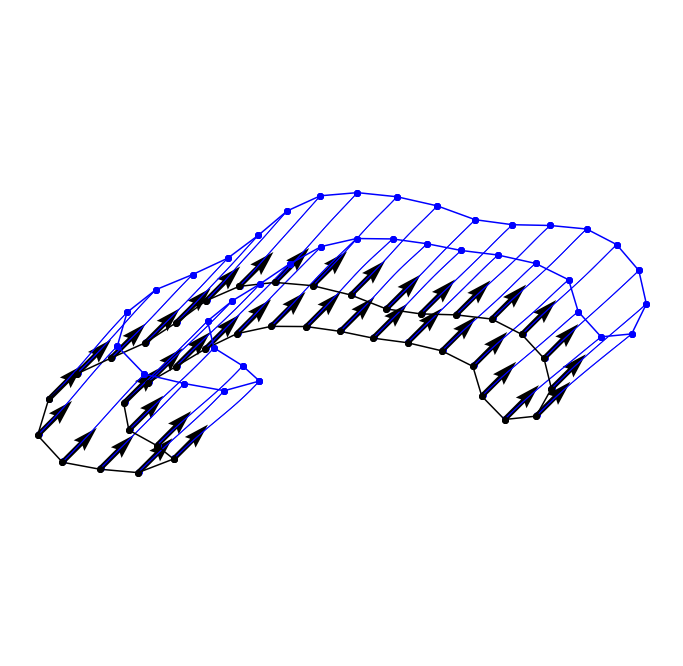

In [31]:
# 2nd order geodesic equation
from src.Riemannian import geodesic
geodesic.initialize(M)

(qs,charts) = M.Exptf(q,v)
M.plot()
M.plot_path(zip(qs,charts),.5*v)
M.plotx(q,color='black',curve=True)
M.plotx(qs[-1],color='blue',curve=True)
plt.axis('off')
plt.savefig('cc_geodesic_forward.pdf')
plt.show()

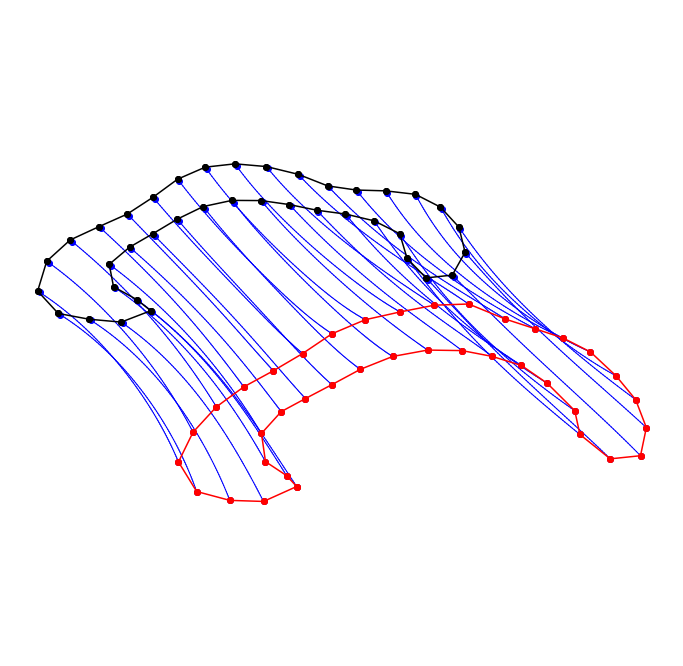

In [36]:
# Logarithm map
from src.dynamics import Hamiltonian
Hamiltonian.initialize(M)
from src.Riemannian import Log
Log.initialize(M,f=M.Exp_Hamiltonian)

p_Log = M.Logf(q,(q1[0]+disp,q[1]))[0]

(qsT,charts) = M.Exp_Hamiltoniantf(q,p_Log)
qs = qsT.T
M.plot()
M.plot_path(zip(qs,charts))
M.plotx(q,color='black',curve=True)
M.plotx(qs[-1],color='red',curve=True)
plt.axis('off')
plt.savefig('cc_geodesic_matching.pdf')
plt.show()

## Brownian Motion

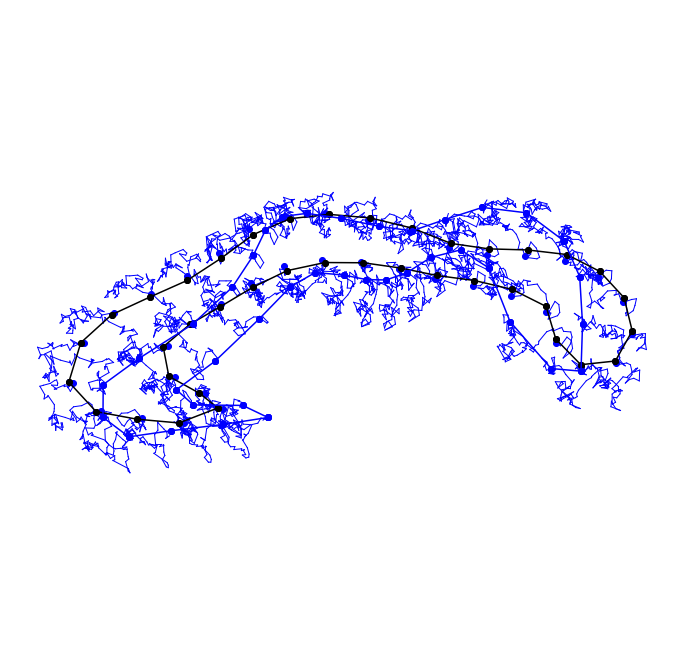

In [37]:
# coordinate form
(ts,qs,charts) = M.Brownian_coordsf(q,.2*dWsf(M.dim.eval()))
M.plot()
M.plot_path(zip(qs,charts))
M.plotx(q,color='black',curve=True)
M.plotx(qs[-1],color='blue',curve=True)
plt.axis('off')
plt.savefig('cc_Brownian.pdf')
plt.show()

# Langevin equations
see https://arxiv.org/abs/1605.09276

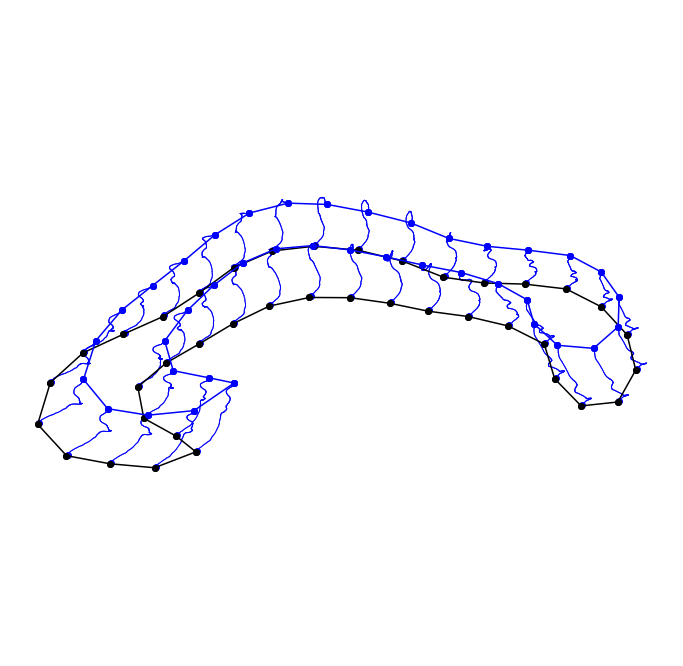

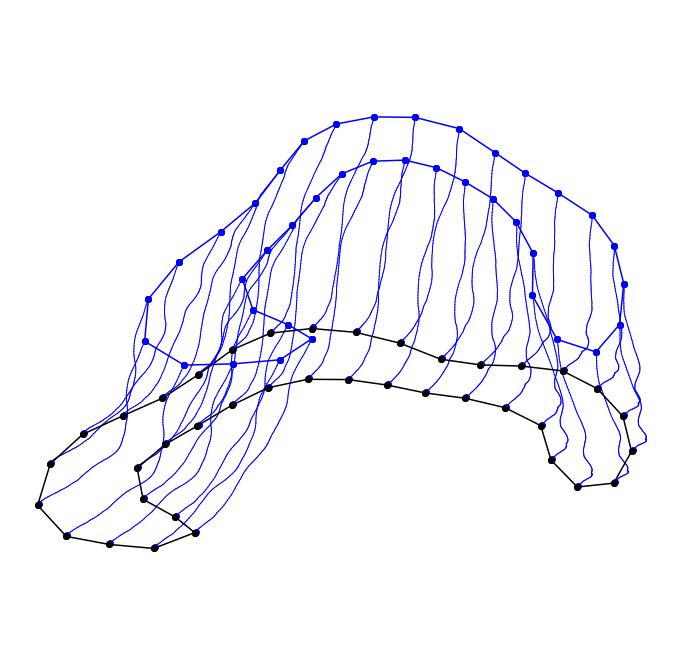

In [38]:
dWs = dWsf(M.dim.eval())

(ts,qps,charts) = M.Langevinf(q,p,.5,.25,dWs)
M.plot()
M.plot_path(zip(qps[:,0,:],charts))
M.plotx(q,color='black',curve=True)
M.plotx(qps[-1,0,:],color='blue',curve=True)
plt.axis('off')
plt.savefig('cc_Langevin.pdf')
plt.show()

(ts,qps,charts) = M.Langevinf(q,p,0.,.25,dWs)
M.plot()
M.plot_path(zip(qps[:,0,:],charts))
M.plotx(q,color='black',curve=True)
M.plotx(qps[-1,0,:],color='blue',curve=True)
plt.axis('off')
plt.savefig('cc_Lagrangian.pdf')
plt.show()

## Stochastic EPDiff / Eulerian

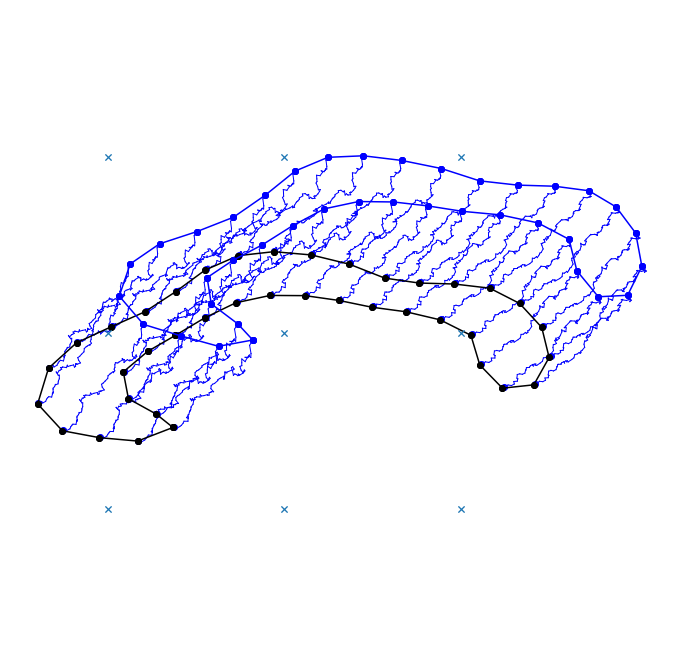

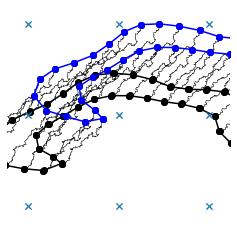

In [39]:
# define noise field grid
minx = -1; maxx = 1
miny = -1; maxy = 1
pts = 3

X, Y = np.meshgrid(np.linspace(minx,maxx,pts),np.linspace(miny,maxy,pts))
xy = np.vstack([X.ravel(), Y.ravel()]).T
sigmas_x = np.hstack((xy,xy)).reshape((-1,2))
sigmas_a = .05*np.tile(np.eye(2),(sigmas_x.shape[0]//2,1))
#sigmas_x = np.array([[0.,0.]])
#sigmas_a = np.array([[.1,0.]])
J = sigmas_x.shape[0]

# noise kernels
k_alpha = 1.
k_sigma = np.diag(((maxx-minx)/(pts-1),(maxy-miny)/(pts-1)))
inv_k_sigma = theano.tensor.nlinalg.MatrixInverse()(k_sigma)
k = lambda x: k_alpha*T.exp(-.5*T.sqr(T.tensordot(x,inv_k_sigma,(0 if x.type == T.vector().type else 2,1))).sum(0 if x.type == T.vector().type else 2))

# initialize with specified noise kernel
from src.stochastics import Eulerian
Eulerian.initialize(M,k=k)

# integrate
(ts,qps,charts) = M.Eulerianf(q,p,sigmas_x.flatten(),sigmas_a.flatten(),dWsf(J))
M.plot()
M.plot_path(zip(qps[:,0,:],charts))
M.plotx(q,color='black',curve=True)
M.plotx(qps[-1,0,:],color='blue',curve=True)
plt.axis('off')
plt.plot(sigmas_x[:,0],sigmas_x[:,1],'x')
plt.savefig('cc_Eulerian.pdf')
plt.show()

plt.figure(figsize=(4,4))
M.plot()
M.plot_path(zip(qps[:,0,:],charts), color='k', linewidth=0.5)
M.plotx(q,color='black',curve=True)
M.plotx(qps[-1,0,:],color='blue',curve=True)
plt.plot(sigmas_x[:,0],sigmas_x[:,1],'x')
plt.axis('off')
plt.axis([-1.2, 1.2, -1.2, 1.2])
plt.savefig('cc_Eulerian.svg')
plt.show()

## Bridge Sampling

In [ ]:
# Delyon/Hu guided process
from src.stochastics.guided_process import *

v = q1

# guide function
Cholesky = T.slinalg.Cholesky()
phi = lambda q,v: T.tensordot(T.nlinalg.MatrixInverse()(Cholesky(M.gsharp(q))),-(q[0]-v).flatten(),(1,0))

(Brownian_coords_guided,Brownian_coords_guidedf) = get_guided_likelihood(
    M,M.sde_Brownian_coords,phi,lambda q: Cholesky(M.gsharp(q)),use_charts=True)

# note that the noise is scaled by .2 (i.e. .2*dWs)
(ts,qs,charts,log_likelihood,log_varphi) = Brownian_coords_guidedf(q,v[0]+disp,.2*dWsf(M.dim.eval()))[:5]
print("log likelihood: ", log_likelihood[-1], ", log varphi: ", log_varphi[-1])

# Visualize bridge
M.plot()
# M.plot_path((q,)+tuple(zip(qs+np.outer(np.linspace(0,1,n_steps.eval()),disp),charts)),curve=True) # translation added to make for nice visual output
M.plot_path((q,)+tuple(zip(qs,charts))) # no translation added
M.plotx(q,color='black',curve=True)
M.plotx((v[0]+disp,v[1]),color='red',curve=True)
plt.axis('off')
plt.savefig('cc_bridge.pdf')